# EM for MLE and MAP

### The Target Distribution
Recall that in our model, we suppose that our data, $\mathbf{X}=\{\mathbf{x}_1, \ldots, \mathbf{x}_K\}$ is drawn from the mixture of $K$ number of Gaussian distributions. For each observation $\mathbf{x}_n$ we have a latent variable $\mathbf{z}_n$ that is a 1-of-$K$ binary vector with elements $z_{nk}$. We denote the set of latent variable by $\mathbf{Z}$. Recall that the distibution of $\mathbf{Z}$ given the mixing coefficients, $\pi$, is given by
\begin{align}
p(\mathbf{Z} | \pi) = \prod_{n=1}^N \prod_{k=1}^K \pi_k^{z_{nk}} 
\end{align}
Recall also that the likelihood of the data is given by,
\begin{align}
p(\mathbf{X} | \mathbf{Z}, \mu, \Sigma) =\prod_{n=1}^N \prod_{k=1}^K \mathcal{N}\left(\mathbf{x}_n| \mu_k, \Sigma_k\right)^{z_{nk}}
\end{align}
Finally, in our basic model, we choose a Dirichlet prior for $\pi$ 
\begin{align}
p(\pi) = \mathrm{Dir}(\pi | \alpha_0) = C(\alpha_0) \prod_{k=1}^K \pi_k^{\alpha_0 -1},
\end{align}
where $C(\alpha_0)$ is the normalizing constant for the Dirichlet distribution. We also choose a Normal-Inverse-Wishart prior for the mean and the covariance of the likelihood function
\begin{align}
p(\mu, \Sigma) = p(\mu | \Sigma) p(\Sigma) = \prod_{k=1}^K \mathcal{N}\left(\mu_k | \mathbf{m}_0, \mathbf{V}_0\right) IW(\Sigma_k|\mathbf{S}_0, \nu_0).
\end{align}
Thus, the joint distribution of all the random variable is given by
\begin{align}
p(\mathbf{X}, \mathbf{Z}, \pi, \mu, \Sigma) = p(\mathbf{X} | \mathbf{Z}, \mu, \Sigma) p(\mathbf{Z} | \pi) p(\pi) p(\mu | \Sigma) p(\Sigma)
\end{align}

### EM for MLE

#### E-step:
*Needs exposition*
\begin{align}
r_{nk} = \frac{\pi_k p\left(\mathbf{x}_n | \mu_k, \Sigma_k\right)}{\sum_{k'=1}^K \pi_{k'} p\left(\mathbf{x}_n | \mu_{k'}, \Sigma_{k'}\right)}
\end{align}

#### M-step:
*Needs exposition*
\begin{align}
\pi_k &= \frac{r_k}{N},\;\; r_k =\sum_{n=1}^N r_{nk}\\
\mu_k &=\frac{\sum_{n=1}^N r_{nk}\mathbf{x}_n}{r_k}\\
\Sigma_k &= \frac{\sum_{n=1}^N r_{nk} \mathbf{x}_n\mathbf{x}_n^\top}{r_k} - \mu_k\mu_k^\top
\end{align}

### EM for MAP

#### E-step:
*Needs exposition*
\begin{align}
r_{nk} = \frac{\pi_k p\left(\mathbf{x}_n | \mu_k, \Sigma_k\right)}{\sum_{k'=1}^K \pi_{k'} p\left(\mathbf{x}_n | \mu_{k'}, \Sigma_{k'}\right)}
\end{align}

#### M-step:
*Needs exposition*
\begin{align}
\pi_k &= \frac{r_k + \alpha_k - 1}{N + \sum_{k=1}^K \alpha_k - K},\;\; r_k =\sum_{n=1}^N r_{nk}\\
\hat{\mu}_k &=\frac{r_k \overline{\mathbf{x}}_k + \beta_0 \mathrm{m}_0}{r_k + \beta_0}\\
\overline{\mathbf{x}}_k&= \frac{\sum_{n=1}^N r_{nk} \mathbf{x}_n}{r_k}\\
\hat{\Sigma}_k &= \frac{\mathbf{S}_0 + \mathbf{S}_k + \frac{\beta_0r_k}{\beta_0 + r_k}(\overline{\mathbf{x}}_k - \mathbf{m}_0)(\overline{\mathbf{x}}_k - \mathbf{m}_0)^\top}{\nu_0 + r_k + D + 2}\\
\mathbf{S}_k &= \sum_{n=1}^N r_{nk} (\mathbf{x}_n - \overline{\mathbf{x}}_k)(\mathbf{x}_n - \overline{\mathbf{x}}_k)^\top
\end{align}


In [52]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.preprocessing import 
from scipy.stats import multivariate_normal as MVN

import re
import numpy as np

In [15]:
#------------------    Real Data    ----------------------#
t1 = time.time()
requests = pd.read_csv('311__Service_Requests.csv')
t2 = time.time()
print "Read in data in %.2f seconds." % (t2 - t1)

t1 = time.time()
closed_requests = requests[requests['CASE_STATUS'] == 'Closed']
t2 = time.time()
print "Filtered data in %.2f seconds." % (t2 - t1)


t1 = time.time()
for col in ['OPEN_DT', 'TARGET_DT', 'CLOSED_DT']:
    closed_requests[col] = pd.to_datetime(closed_requests[col], infer_datetime_format=True)
t2= time.time()
print "Dates processed in %.2f seconds." % (t2 - t1)

Read in data in 8.81 seconds.
Filtered data in 0.37 seconds.
Dates processed in 398.70 seconds.


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
########################################
########################################
#####       Makes real data        #####
########################################
########################################

def real_data(begin_date, end_date):
    begin = pd.to_datetime(begin_date) 
    end = pd.to_datetime(end_date)

    in_range = closed_requests[closed_requests['OPEN_DT'] > begin]
    in_range = in_range[in_range['OPEN_DT'] < end]
    
    elapsed_time = in_range['CLOSED_DT'].values - in_range['OPEN_DT'].values
    elapsed_time = elapsed_time.astype('timedelta64[h]').astype('float64')

    data = np.hstack((elapsed_time.reshape((len(in_range), 1)), 
                      in_range['LATITUDE'].values.reshape((len(in_range), 1)), 
                      in_range['LONGITUDE'].values.reshape((len(in_range), 1))))
    return data

In [19]:
########################################
########################################
#####       Makes test data        #####
########################################
########################################

def test_data(N, D):
    n_samples = int(N/2.0) #number of points in each component
    mu1 = np.array([10] * D) #mean of component 1
    mu2 = np.array([6] * D) #mean of component 1

    # generate random sample, two components
    np.random.seed(0)

    # generate spherical data centered on mu1
    comp1 = np.random.randn(n_samples, D) + mu1
    
    # generate spherical data centered on mu2
    comp2 = np.random.randn(N - n_samples, D) + mu2

    # concatenate the two datasets into training set
    data = np.vstack([comp1, comp2])

    #plot the components
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(comp1[:, 0], comp1[:, 1], comp1[:, 2], c='r')
    ax.scatter(comp2[:, 0], comp2[:, 1], comp2[:, 2], c='b')

    plt.title('test data')
    plt.show()
    
    return data

In [72]:
########################################
########################################
###   K-means init for mu and Sigma  ###
########################################
########################################

def k_means(N, D, K, X):
    kmeans = KMeans(init='random', n_clusters=K, n_init=K) #k-means++
    kmeans.fit(data)
    mu = kmeans.cluster_centers_
    labels = kmeans.predict(X)
    
    clusters = [labels[labels == k].shape[0] for k in xrange(K)]    
    pi = np.array([clusters[k] / (1. * sum(clusters)) for k in xrange(K)])
    
    clusters = [[X[n] for n in xrange(N) if labels[n] == k] for k in xrange(K)]
    
    Sigma = []
    for k in xrange(K):
        Sigma_k = np.zeros((D, D))
        for pt in clusters[k]:
            Sigma_k += np.outer(pt, pt)
        Sigma.append(Sigma_k - len(clusters[k]) * np.outer(mu[k], mu[k]))
        
    return pi, mu, Sigma

In [49]:
########################################
########################################
#####         EM for MLE           #####
########################################
########################################

def MLE_EM(K, D, N, X, pi_0, mu_0, Sigma_0, iters):
    
    #initialization of parameters    
    r = np.zeros((N, K)) #responsibility of each cluster for each data pt
    pi = pi_0 #mixture coefficients
    mu = mu_0 #means (K x D) matrix
    Sigma = Sigma_0 #coveriances length-k list of (K x K) matrices
    
    #---------------- Likelihood ----------------#    
    def lkhd(pi, mu, Sigma):
        prob = np.zeros((N, K))
        for k in xrange(K):
            prob[:, k] = pi[k] * MVN.pdf(X, mu[k, :], Sigma[k])
        return np.nan_to_num(prob)
    
    #---------------- E-Step ----------------#
    def E_step():
        prob = lkhd(pi, mu, Sigma) 
        return np.nan_to_num(np.diag(np.reciprocal(np.sum(prob, axis=1))).dot(prob))
    
    #---------------- M-Step ----------------#
    def M_step():
        r_ks = np.sum(r, axis=0)
        pi_new = 1. / N * r_ks
        mu_new = np.nan_to_num(np.diag(np.reciprocal(r_ks)).dot(r.T.dot(X)))
        
        Sigma_new = []
        for k in xrange(K):
            Sigma_k = np.zeros((D, D))
            for n in xrange(N):
                Sigma_k += r[n, k] * np.outer(X[n, :] - mu[k, :], X[n, :] - mu[k, :])
            Sigma_new.append(np.nan_to_num(Sigma_k / r_ks[k]))
            
        return pi_new, mu_new, Sigma_new
    
    #---------------- Alternate Between E and M-steps ----------------#
    for i in xrange(iters):        
        r = E_step()
        pi, mu, Sigma = M_step()
        
    r = E_step()
    
    return pi, mu, Sigma, r

########################################
########################################
#####         EM for MAP           #####
########################################
########################################

def MAP_EM(K, D, N, X, pi_0, mu_0, Sigma_0, S_0, m_0, nu_0, beta_0, alpha_0, iters):
    
    #initialization of intermediate parameters
    r = np.zeros((N, K)) #responsibility of each cluster for each data pt
    pi = pi_0 #mixture coefficients
    mu = mu_0 #means (K x D) matrix
    Sigma = Sigma_0 #coveriances length-k list of (K x K) matrices
    S = [np.eye(D) for k in xrange(K)] #(K x K) scatter matrices
    X_mean = mu_0 #mean of pts in each cluster (K x D) matrix
    
    #---------------- Likelihood ----------------#    
    def lkhd(pi, mu, Sigma):
        prob = np.zeros((N, K))
        for k in xrange(K):
            prob[:, k] = pi[k] * MVN.pdf(X, mu[k, :], Sigma[k])        
        return prob
    
    #---------------- E-Step ----------------#
    def E_step():
        prob = lkhd(pi, mu, Sigma) 
        return np.diag(np.reciprocal(np.sum(prob, axis=1))).dot(prob)
        
    
    #---------------- M-Step ----------------#
    def M_step():
        r_ks = np.sum(r, axis=0)
        pi_new = (r_ks + alpha_0 - 1) * 1. / (N + np.sum(alpha_0) - K)
        X_mean_new = np.nan_to_num(np.diag(np.reciprocal(r_ks)).dot(r.T.dot(X)))
        mu_new = np.nan_to_num(np.diag(np.reciprocal(r_ks 
                                                     + beta_0)).dot(np.diag(r_ks).dot(X_mean) 
                                                                    + beta_0 * m_0))
        S_new = []
        Sigma_new = []
        for k in xrange(K):            
            c_1 = (beta_0 * r_ks[k]) / (beta_0 + r_ks[k])
            c_2 = nu_0 + r_ks[k] + D + 2
            Sigma_k = np.nan_to_num(S_0 + S[k] + c_1 
                                    * np.outer(X_mean[k, :] - m_0, X_mean[k, :] - m_0))
            Sigma_new.append(Sigma_k * 1./c_2)
            
            S_k = np.zeros((D, D))
            for n in xrange(N):
                S_k += r[n, k] * np.outer(X[n, :] - X_mean[k, :], X[n, :] - X_mean[k, :])
                
            S_new.append(S_k)
        return pi_new, X_mean_new, mu_new, S_new, Sigma_new
        
    #---------------- Alternate Between E and M-steps ----------------#
    for i in xrange(iters): 
        r = np.nan_to_num(E_step())
        pi, X_mean, mu, S, Sigma = M_step()
        
    r = E_step()
    
    return pi, X_mean, mu, S, Sigma, r

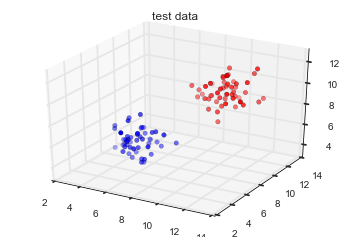

******************* K-means
mixture: [ 0.5  0.5]
mu [[ 10.27935454  10.21207876   9.88471757]
 [  5.92168648   6.00042586   5.86691424]]
Sigma: [[ 55.95336916  -0.63653443   7.65032885]
 [ -0.63653443  50.16360724   5.18890337]
 [  7.65032885   5.18890337  45.56551815]]
Sigma: [[ 46.12307462  -8.74191667   3.34517806]
 [ -8.74191667  45.15409447  -7.48072604]
 [  3.34517806  -7.48072604  49.68106486]]
******************* MLE
mixture: [ 0.50000102  0.49999898]
mu [[ 10.27935003  10.2120724    9.88470953]
 [  5.92168214   6.00042366   5.86691412]]
Sigma: [[ 1.11907542 -0.01271641  0.15302376]
 [-0.01271641  1.00329059  0.10380241]
 [ 0.15302376  0.10380241  0.91134115]]
Sigma: [[ 0.92245377 -0.17484352  0.06690379]
 [-0.17484352  0.90308079 -0.14961433]
 [ 0.06690379 -0.14961433  0.9936225 ]]


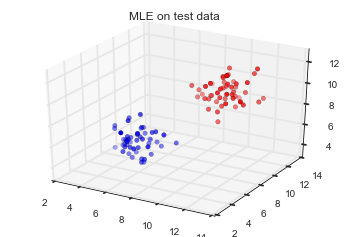

******************* MAP
mixture: [ 0.49622883  0.50377117]
mu [[ 10.20221263  10.1340988    9.80863786]
 [  5.87680436   5.95656379   5.82474866]]
Sigma: [[ 1.60612493  0.62928717  0.74972245]
 [ 0.62928717  1.50604493  0.70791706]
 [ 0.74972245  0.70791706  1.39170124]]
Sigma: [[ 1.00423     0.0620464   0.26422679]
 [ 0.0620464   0.99738045  0.08396483]
 [ 0.26422679  0.08396483  1.06520781]]


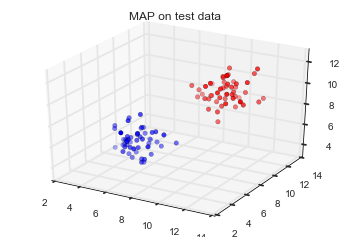

In [50]:
########################################
########################################
#####     Run on test data         #####
########################################
########################################

#-------------   run parameters
iters = 500

#-------------   test data parameters
K = 2 #number of components
N = 100 #number of observations
D = 3 #number of attributes per observation

data = test_data(N, D) #make test data

#---------------- K-means initialization for MLE ----------------#
N = data.shape[0] #number of observations
K = 2 #number of components
D = data.shape[1] #number of features per observation

pi, mu, Sigma = k_means(N, D, K, data)

print '******************* K-means'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]


#---------------- MLE ----------------#
pi, mu, Sigma, r = MLE_EM(K, D, N, data, pi, mu, Sigma, iters)

print '******************* MLE'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]

#plot the components
for n in xrange(N):
    r_n = r[n, :]
    r_n[r_n < np.max(r_n)] = 0
    r_n[r_n == np.max(r_n)] = 1
    r[n, :] = r_n

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

clu0 = np.asarray([data[n] for n in xrange(N) if r[n, 0] == 1])
clu1 = np.asarray([data[n] for n in xrange(N) if r[n, 1] == 1])

ax.scatter(clu0[:, 0], clu0[:, 1], clu0[:, 2], c='r')
ax.scatter(clu1[:, 0], clu1[:, 1], clu1[:, 2], c='b')

plt.title('MLE on test data')
plt.show()

#---------------- MAP ----------------#

#random initialization of hyperparameters
alpha_0 = np.random.random(K)
beta_0 = np.random.random()
m_0 = np.zeros(D)
S_0 = np.eye(D)
nu_0 = D + 1

pi, X_mean, mu, S, Sigma, r = MAP_EM(K, D, N, data, pi, mu, Sigma, S_0, m_0, nu_0, beta_0, alpha_0, iters)

print '******************* MAP'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]

#plot the components
for n in xrange(N):
    r_n = r[n, :]
    r_n[r_n < np.max(r_n)] = 0
    r_n[r_n == np.max(r_n)] = 1
    r[n, :] = r_n
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

clu0 = np.asarray([data[n] for n in xrange(N) if r[n, 0] == 1])
clu1 = np.asarray([data[n] for n in xrange(N) if r[n, 1] == 1])

ax.scatter(clu0[:, 0], clu0[:, 1], clu0[:, 2], c='r')
ax.scatter(clu1[:, 0], clu1[:, 1], clu1[:, 2], c='b')

plt.title('MAP on test data')
plt.show()

(5294, 3)
(5294, 3)
before [ 111.       42.3387  -71.0979]
after [-0.22556302  0.46652323 -0.2687283 ]
******************* K-means
mixture: [ 0.  1.]
mu [[ 7631.08780488    42.32327463   -71.08155805]
 [  187.43859304    42.32212311   -71.08821165]]
Sigma: [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
Sigma: [[ -1.85990005e+08  -4.19962000e+07   7.05409205e+07]
 [ -4.19962000e+07  -9.47711818e+06   1.59303671e+07]
 [  7.05409205e+07   1.59303671e+07  -2.67481141e+07]]


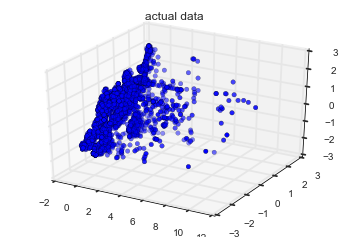

In [73]:
########################################
########################################
#####     Run on real data         #####
########################################
########################################

data = real_data('March 15, 2014 12:00PM', 'March 30, 2014 12:00PM')
data_std = scale(data)
#data_norm = normalize(data)
print data.shape

print 'before', data[500]
print 'after', data_std[500]

#---------------- K-means initialization for MLE ----------------#
N = data.shape[0] #number of observations
K = 2 #number of components
D = data.shape[1] #number of features per observation

pi, mu, Sigma = k_means(N, D, K, data_std)

print '******************* K-means'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_std[:, 0], data_std[:, 1], data_std[:, 2], c='b')

plt.title('actual data')
plt.show()

(2, 3)
******************* MAP
mixture: [ 0.98744289  0.01255711]
mu [[ -1.34076787e-02  -5.83391661e-02   8.52039312e-02]
 [  2.50212839e-06   1.08872261e-05  -1.59006890e-05]]
Sigma: [[  1.91080243e-04   2.87000580e-07  -3.93334994e-07]
 [  2.87000580e-07   1.92021437e-04  -1.42002842e-06]
 [ -3.93334994e-07  -1.42002842e-06   1.92971527e-04]]
Sigma: [[  74.40378762  -11.73354428   30.72850147]
 [ -11.73354428   99.2720564   -35.05910978]
 [  30.72850147  -35.05910978  242.73683187]]


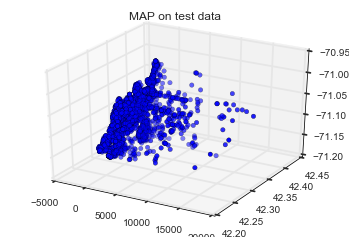

In [78]:
#---------------- MAP ----------------#

#random initialization of hyperparameters
alpha_0 = np.random.random(K)
beta_0 = np.random.random()
m_0 = np.zeros(D)
S_0 = np.eye(D)
nu_0 = D + 1

mu_ind = np.random.randint(len(data_std), size=2)
mu = np.asarray([data_std[mu_ind[0]], data_std[mu_ind[1]]])
print mu.shape

Sigma[0] = 100 * np.eye(D)
Sigma[1] = 100 * np.eye(D)

pi, X_mean, mu, S, Sigma, r = MAP_EM(K, D, N, data_std, pi, mu, Sigma, S_0, m_0, nu_0, beta_0, alpha_0, iters)

print '******************* MAP'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]

#plot the components
for n in xrange(N):
    r_n = r[n, :]
    r_n[r_n < np.max(r_n)] = 0
    r_n[r_n == np.max(r_n)] = 1
    r[n, :] = r_n
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

clu0 = np.asarray([data[n] for n in xrange(N) if r[n, 0] == 1])
clu1 = np.asarray([data[n] for n in xrange(N) if r[n, 1] == 1])

ax.scatter(clu0[:, 0], clu0[:, 1], clu0[:, 2], c='r')
ax.scatter(clu1[:, 0], clu1[:, 1], clu1[:, 2], c='b')

plt.title('MAP on test data')
plt.show()